# Data treatment and exploration for report

## Gain access to SQL database

In [1]:
# Import the nessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [2]:
db = sqlite3.connect("data/full_database.db")

In [3]:
res = db.execute("SELECT * FROM data LIMIT 10")
for row in res:
    print(row)

('0', '2', 'express.co.uk', 'rumor', 'https://www.express.co.uk/news/science/738402/life-an-ILLUSION-reality-does-not-exist-if-you-are-not-looking-at-it', 'Life is an illusion, at least on a quantum level, in a theory which has recently been confirmed by a set of researchers.  They finally have the means to test John Wheeler’s delayed-choice theory and concluded that the physicist was right.  In 1978, Mr Wheeler’s proposed experiment involved a moving object that was given the choice to act like a wave or a particle – the former acting as a vibration with a frequency that can distinguish it from other waves and the latter having no frequency that you can determine its position in space, unlike a wave – and at what point does it ‘decide’ to act like one or the other.  At the time, the technology was not available to conduct a strong experiment, but scientists have now been able to carry it out.', '2018-01-25 16:17:44.789555', '2018-02-02 01:19:41.756632', '2018-02-02 01:19:41.756664', "

## Summary statistics

### How many of each type?

We first need to retrieve the requested data from the database.

In [4]:
# Convert the data to a dataframe
df = pd.read_sql_query("SELECT COUNT(type), type FROM data GROUP BY type", db)
df

,COUNT(type),type
0,403211,
1,1138998,bias
2,231949,clickbait
3,831235,conspiracy
4,894746,fake
5,76496,hate
6,117467,junksci
7,1657224,political
8,1913222,reliable
9,481158,rumor


Since the first row contains all the "missing" types we will rename the type in the first row to "missing". We will also rename the columns to be a bit more readable.

In [5]:
# Rename columns
df.rename(columns={"COUNT(type)": "count", "type": "type"}, inplace=True)

# Change the firs row so that the type is missing
df.loc[0, "type"] = "missing"

In [6]:
# Sort in descending order
df.sort_values(by="count", ascending=False, inplace=True)

Text(0.5, 1.0, 'Number of articles per type')

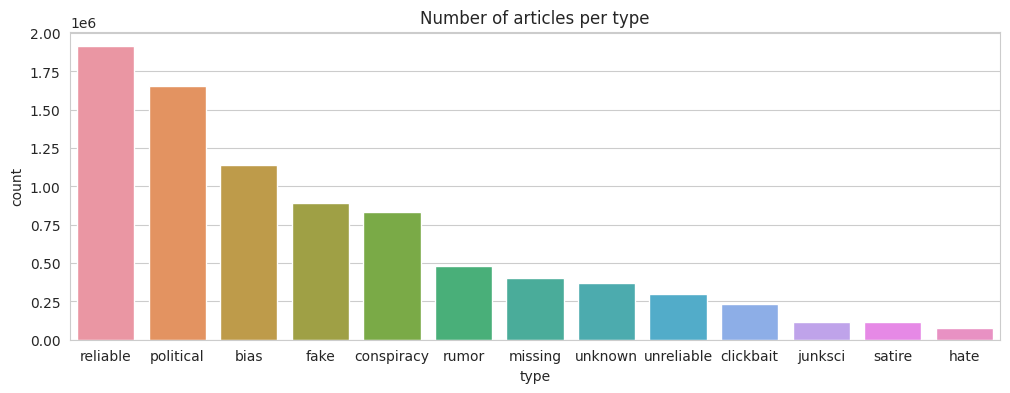

In [7]:
# Lets now plot the data
plt.figure(figsize=(12, 4))
sns.set_style("whitegrid")
sns.barplot(x="type", y="count", data=df)
plt.title("Number of articles per type")

We see that the the most prolific category is reliable, followed by political. These two are far ahead of the rest of the types. Here we also notice that *403211* articles are missing their type. 

### Articles pr. domain

In [8]:
df = pd.read_sql_query("SELECT COUNT(domain), domain FROM data GROUP BY domain", db)
df

,COUNT(domain),domain
0,97,100percentfedup.com
1,1,16wmpo.com
2,19897,21stcenturywire.com
3,267,21wire.tv
4,5394,4threvolutionarywar.wordpress.com
...,...,...
730,10620,yournewswire.com
731,2672,zeenews.india.com
732,1,zengardner.com
733,36533,zerohedge.com


In [9]:
# Rename columns
df.rename(columns={"COUNT(domain)": "count", "domain": "domain"}, inplace=True)

# Sort in descending order
df.sort_values(by="count", ascending=False, inplace=True)

# Select the 10 most common domains
df = df.iloc[:10]

Text(0.5, 1.0, 'Number of articles per domain')

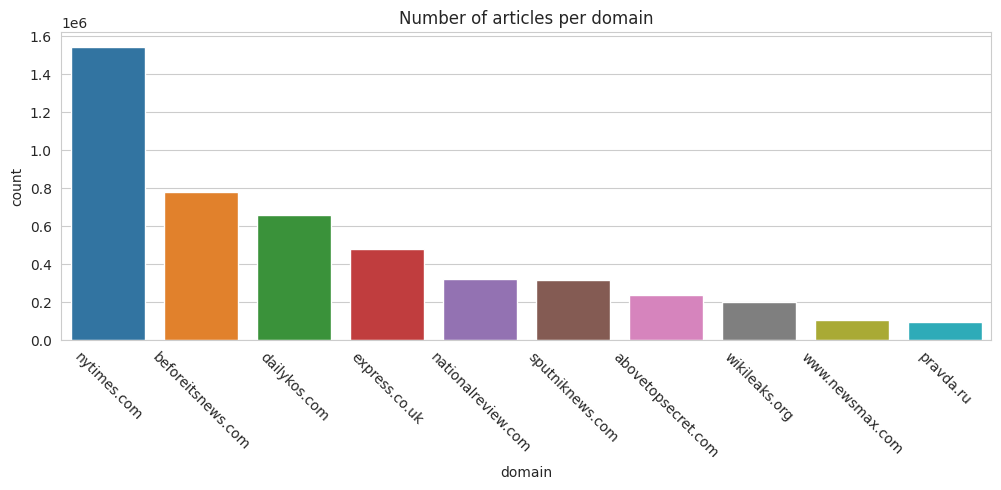

In [10]:
# Lets now plot the data
plt.figure(figsize=(12, 4))
sns.set_style("whitegrid")
# Angled x labels
plt.xticks(rotation=-45)
sns.barplot(x="domain", y="count", data=df)
plt.title("Number of articles per domain")

## Non trivial observations

### Duplicate articles

In [11]:
df = pd.read_sql_query(
    'SELECT domain, type, content, COUNT() AS "Count" FROM data GROUP BY content ORDER BY Count() DESC LIMIT 10;',
    db,
)

In [12]:
df

,domain,type,content,Count
0,nationalreview.com,political,Plus one article on Google Plus (Thanks to Al...,273388
1,wikileaks.org,unreliable,Tor Tor is an encrypted anonymising network t...,169259
2,sputniknews.com,bias,"Dear readers, we are excited to announce that ...",102671
3,abovetopsecret.com,conspiracy,It looks like you're using an Ad Blocker. Ple...,72978
4,investmentwatchblog.com,bias,It only takes a few moments to share an articl...,35490
5,dailykos.com,political,"© Kos Media, LLC Site content may be used for...",29649
6,sputniknews.com,bias,E-mail: Screen Name: Password: Confirm pass...,27668
7,lifenews.com,bias,FAIR USE NOTICE. Many of the stories on this s...,24796
8,express.co.uk,rumor,Express. Home of the Daily and Sunday Express.,23216
9,nytimes.com,reliable,Opinion » Should Beach Privatization Be Allowe...,23035


### Domain classification
One perculiar thing we encountered whilst exploring the data, was the fact that all the articles from any given domain are labeled the same. I.e. all the articles from the New York Times were labeled as reliable.

In [13]:
df = pd.read_sql_query(
    'SELECT COUNT(type), type FROM data WHERE domain = "www.nytimes.com" GROUP BY type',
    db,
)
df

,COUNT(type),type
0,4550,reliable


This shows that the creator of the dataset assumes that an articles reliability comes from the specific publisher / domain to which it is published. Whilst this assumption has no doubt made the scraping of articles easier, it is a very problematic assumption both in ethical and practical terms